In [1]:
#pip install -U -q tensorflow tensorflow_datasets

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATASET_PATH = 'data2'

data_dir = pathlib.Path(DATASET_PATH)


In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

print('Commands:', commands)

Commands: ['arasa' 'BARABAR' 'Bilkul' 'MULI']


In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 4000 files belonging to 4 classes.
Using 3200 files for training.
Using 800 files for validation.

label names: ['BARABAR' 'Bilkul' 'MULI' 'arasa']


In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [6]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [7]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
train_ds

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
val_ds

<_ShardDataset element_spec=(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [11]:
label_names[[1,1,3,0]]

array(['Bilkul', 'Bilkul', 'arasa', 'BARABAR'], dtype='<U7')

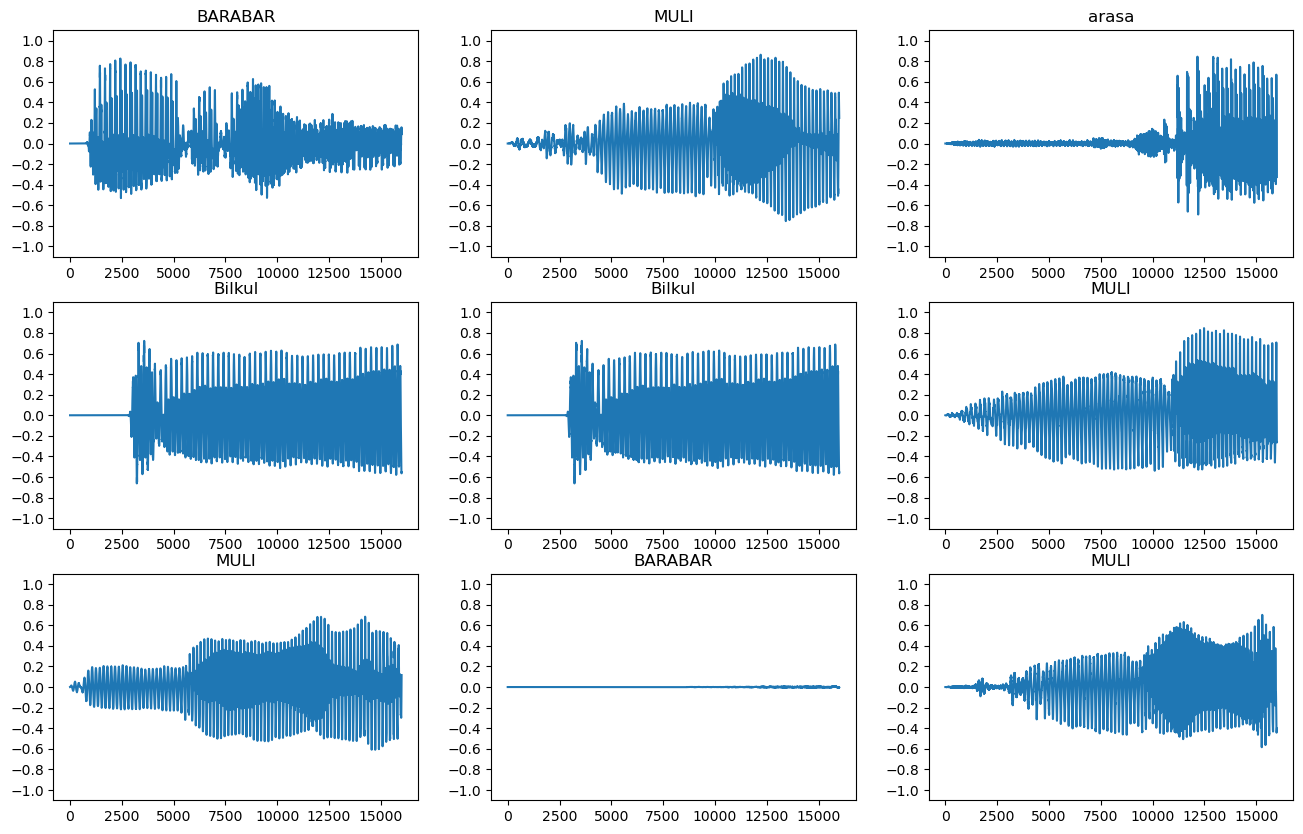

In [12]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [14]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: BARABAR
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: MULI
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: arasa
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

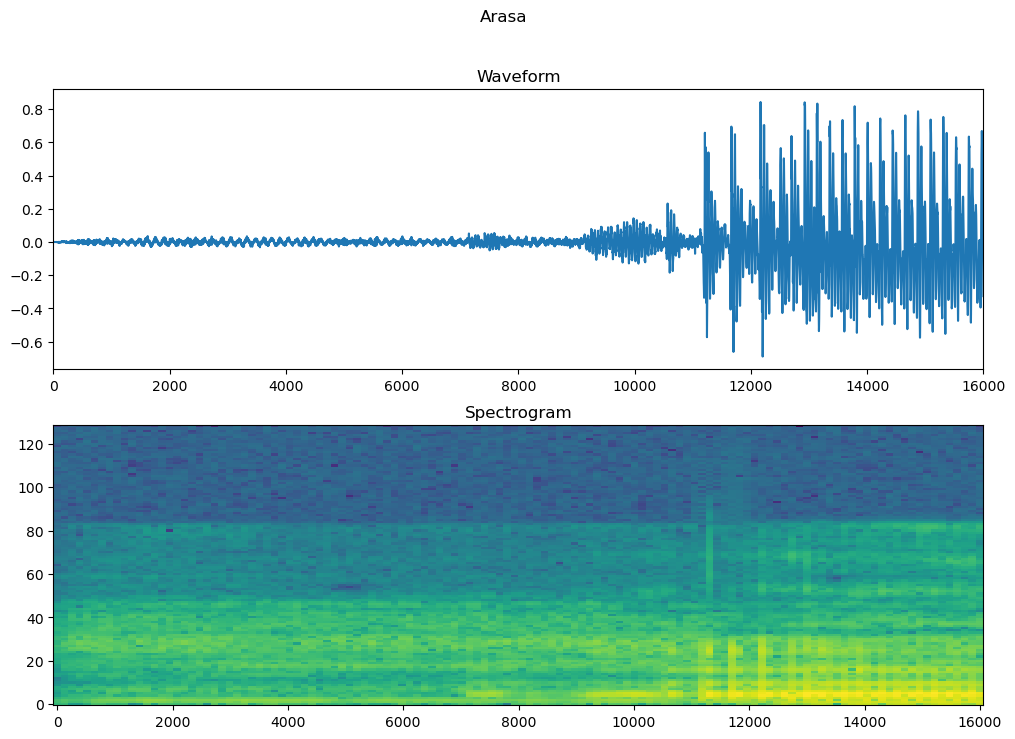

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [17]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

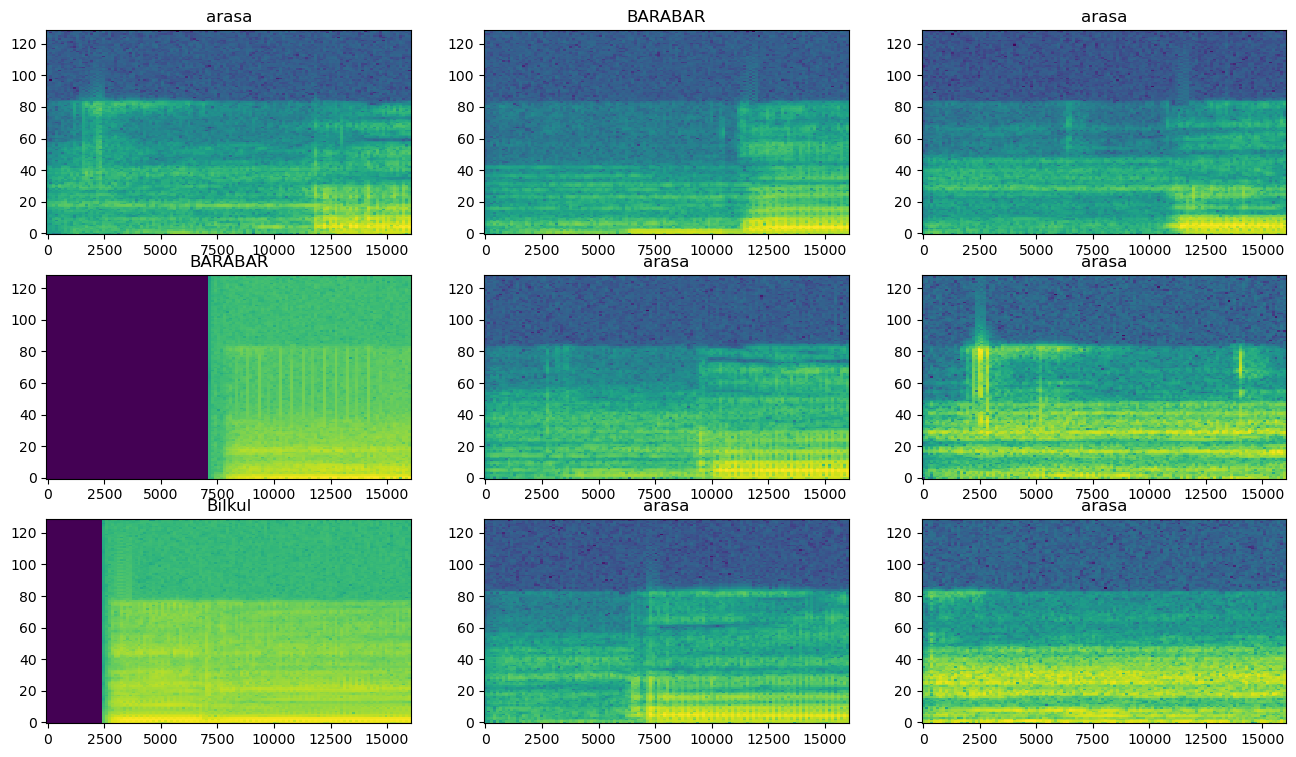

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [24]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
50/50 [==============================] - 10s 160ms/step - loss: 0.3308 - accuracy: 0.8691 - val_loss: 0.0708 - val_accuracy: 0.9714
Epoch 2/10
50/50 [==============================] - 7s 132ms/step - loss: 0.0714 - accuracy: 0.9784 - val_loss: 0.0293 - val_accuracy: 0.9922
Epoch 3/10
50/50 [==============================] - 7s 133ms/step - loss: 0.0356 - accuracy: 0.9897 - val_loss: 0.0241 - val_accuracy: 0.9922
Epoch 4/10
50/50 [==============================] - 7s 136ms/step - loss: 0.0306 - accuracy: 0.9900 - val_loss: 0.0153 - val_accuracy: 0.9922
Epoch 5/10
50/50 [==============================] - 7s 136ms/step - loss: 0.0284 - accuracy: 0.9912 - val_loss: 0.0198 - val_accuracy: 0.9922
Epoch 6/10
50/50 [==============================] - 7s 136ms/step - loss: 0.0302 - accuracy: 0.9891 - val_loss: 0.0103 - val_accuracy: 0.9922
Epoch 7/10
50/50 [==============================] - 7s 135ms/step - loss: 0.0101 - accuracy: 0.9975 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch

Text(0, 0.5, 'Accuracy [%]')

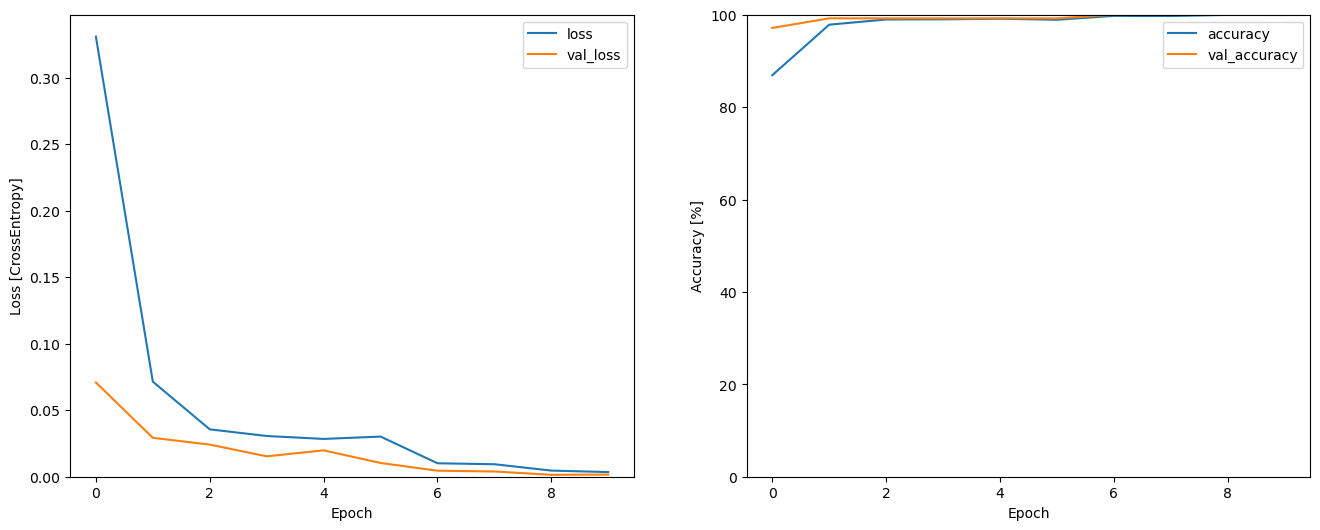

In [25]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [26]:
model.evaluate(test_spectrogram_ds, return_dict=True)

7/7 [==============================] - 1s 103ms/step - loss: 0.0011 - accuracy: 1.0000


{'loss': 0.0011464206036180258, 'accuracy': 1.0}

In [27]:
y_pred = model.predict(test_spectrogram_ds)

7/7 [==============================] - 0s 32ms/step


In [28]:
y_pred = tf.argmax(y_pred, axis=1)

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

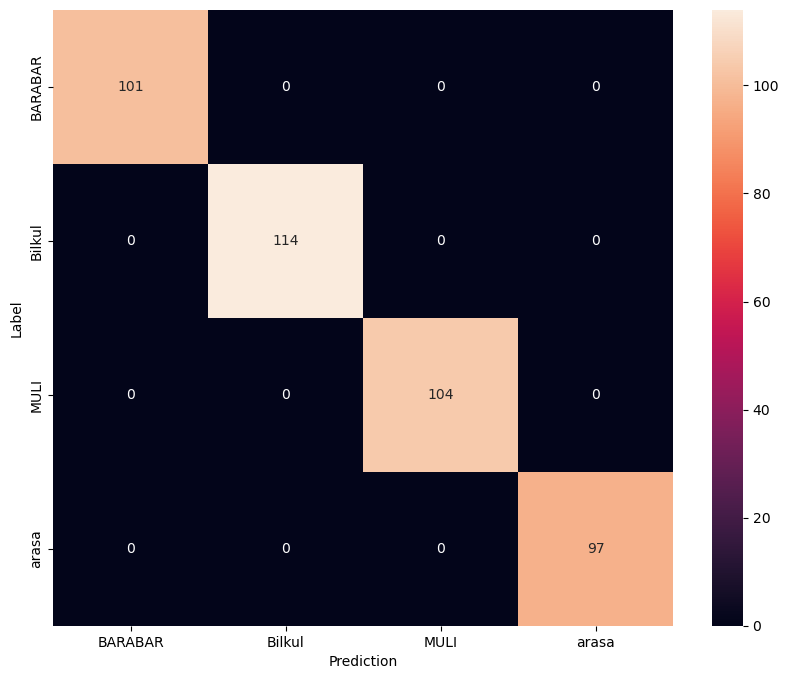

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

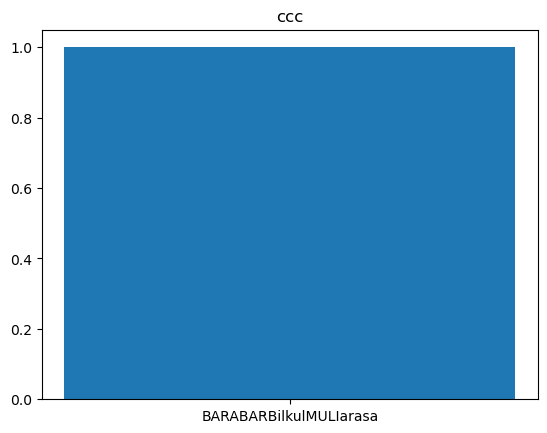

In [31]:
x = '20.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels =['BARABAR' 'Bilkul' 'MULI' 'arasa']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('ccc')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [32]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [33]:
export = ExportModel(model)
export(tf.constant(str('20.wav')))

{'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[  8.852352, -19.056646, -11.456041,  37.274265]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'arasa'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [34]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


{'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[  8.852352, -19.056646, -11.456041,  37.274265]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'arasa'], dtype=object)>}

In [35]:
export = ExportModel(model)
export(tf.constant(str('14.wav')))

{'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
 array([[ 2.6942404e+01, -1.1099533e+01, -1.2272337e-02,  4.8109875e+00]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'BARABAR'], dtype=object)>}

In [36]:
export = ExportModel(model)
export(tf.constant(str('9.wav')))

{'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[-10.185519,  41.11896 ,  15.125284, -26.844456]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Bilkul'], dtype=object)>}

In [37]:
export = ExportModel(model)
export(tf.constant(str('41.wav')))

{'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
 array([[-19.796457  ,   0.67532516,  36.09321   , -12.554332  ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'MULI'], dtype=object)>}

In [38]:
export = ExportModel(model)
export(tf.constant(str('new.wav')))

{'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
 array([[-19.796457  ,   0.67532516,  36.09321   , -12.554332  ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'MULI'], dtype=object)>}

In [39]:
export = ExportModel(model)
export(tf.constant(str('p.wav')))

{'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[-10.185519,  41.11896 ,  15.125284, -26.844456]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Bilkul'], dtype=object)>}

In [40]:
export = ExportModel(model)
export(tf.constant(str('s.wav')))

{'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[25.982153 , -8.960358 ,  4.9961705, -3.9752495]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'BARABAR'], dtype=object)>}

In [41]:
a=export(tf.constant(str('9.wav')))

In [42]:
s=str(a['class_names'])

In [43]:
i1=s.index("b'")+2

In [44]:
i2=s.index("']")

In [45]:
cname=s[i1:i2]
cname

'Bilkul'

In [46]:
import pandas as pd
df=pd.read_excel('word_meanings.xlsx')
df

,Word,telugu,tamil,hindi,urdu,Marathi,Kannada
0,Puli,tiger,tamarind,NaN,NaN,NaN,NaN
1,Kodi,chicken,flag/banner,NaN,NaN,NaN,NaN
2,Ma,month,great/big,NaN,NaN,NaN,NaN
3,Pora,to search,fight/battle,NaN,NaN,NaN,NaN
4,Maata,word/speech,cow,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
72,dhoka,NaN,NaN,betrayal,NaN,danger,NaN
73,shikka,NaN,NaN,coin,NaN,stamp/seal,NaN
74,barabar,NaN,NaN,equal,NaN,correct,NaN
75,muli,NaN,NaN,raddish,NaN,girls,NaN


In [47]:
def get_properties(word):
    global df
    c=0
    if word in df['Word'].values:
        print(f"{word} is present in the 'Word' column.")
        row_number = df.index[df['Word'] == word].tolist()[0] + 1
        print(row_number-1)
        print(df.iloc[row_number-1])
        telugu=df.iloc[row_number-1]['telugu']
        tamil=df.iloc[row_number-1]['tamil']
        hindi=df.iloc[row_number-1]['hindi']
        urdu=df.iloc[row_number-1]['urdu']
        Marathi=df.iloc[row_number-1]['Marathi']
        Kannada=df.iloc[row_number-1]['Kannada']
        print('telugu',telugu)
        print('tamil',tamil)
        print('hindi',hindi)
        print('urdu',urdu)
        print('Marathi',Marathi)
        print('Kannada',Kannada)
        f=open('details.txt','w')
        f.write(str(telugu)+'##'+str(tamil)+'##'+str(hindi)+'##'+str(urdu)+'##'+str(Marathi)+'##'+str(Kannada))
        f.close()
    else:
        print(f"{word} is not present in the 'Word' column.")

In [48]:
from pydub import AudioSegment
import os

def convert_wav_to_mono(input_folder, output_folder):
    # Iterate through each WAV file in the input folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".wav"):
            # Load the WAV file
            audio = AudioSegment.from_wav(os.path.join(input_folder, file_name))
            
            # Convert stereo to mono
            audio = audio.set_channels(1)
           
            # Output file path for the mono WAV file
            output_path = os.path.join(output_folder, os.path.splitext(file_name)[0] + "_mono.wav")
           
            # Export the audio to mono WAV format
            audio.export(output_path, format="wav")

C:\Users\Lenovo\anaconda3\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [49]:
from pydub import AudioSegment
import os

def convert_wav_to_mono1(input_folder, output_folder,fname):
    # Iterate through each WAV file in the input folder
    #Load the WAV file
    #audio = AudioSegment.from_wav(os.path.join(input_folder, file_name))
    print(input_folder+'/'+fname)
    audio = AudioSegment.from_wav(input_folder+'/'+fname)
    # Convert stereo to mono
    audio = audio.set_channels(1)

    # Output file path for the mono WAV file
    output_path =output_folder+'/'+fname

    # Export the audio to mono WAV format
    audio.export(output_path, format="wav")

In [50]:
def predict(apath):
    a=export(tf.constant(str(apath)))
    s=str(a['class_names'])
    i1=s.index("b'")+2
    i2=s.index("']")
    cname=s[i1:i2]
    return cname
    

In [51]:
pclass=predict('temp1/recorded_speech.wav')
print(pclass)
get_properties(pclass.lower())

NotFoundError: Graph execution error:

Detected at node ReadFile defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Lenovo\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Lenovo\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Lenovo\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code

  File "C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13120\952804455.py", line 1, in <module>

  File "C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13120\914656804.py", line 7, in __init__

  File "C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13120\914656804.py", line 16, in __call__

  File "C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13120\914656804.py", line 17, in __call__

NewRandomAccessFile failed to Create/Open: temp1/recorded_speech.wav : The system cannot find the file specified.
; No such file or directory
	 [[{{node ReadFile}}]] [Op:__inference___call___10570]

In [52]:
import tkinter as tk
from tkinter import PhotoImage
import pygame
import sounddevice as sd
import soundfile as sf
path='C:/Users/Lenovo/Desktop/Language/'
class FullScreenApp:
    def __init__(self, master):
        self.master = master
        master.title("Full Screen App")
        master.attributes('-fullscreen', False)  # Full-screen mode

        # Load images
        self.image1 = PhotoImage(file="images.png")
        

        # Display images
        self.label1 = tk.Label(master, image=self.image1)
        self.label1.pack(side="top", fill="both", expand=True)
        self.label1.bind("<Button-1>", lambda event: self.show_image(self.image1))
        
        self.exit_button = tk.Button(master, text="Exit", command=self.exit_app)
        self.exit_button.pack(side="bottom", pady=20)
        
        self.predict_button = tk.Button(master, text="Analysis", command=self.predict_audio)
        self.predict_button.pack(side="bottom", pady=20)
        
        self.play_button = tk.Button(master, text="Play", command=self.play_audio)
        self.play_button.pack(side="bottom", pady=20)
        
        self.record_button = tk.Button(master, text="Record", command=self.record_audio)
        self.record_button.pack(side="bottom", pady=20)
        # Buttons
        

        

    def show_image(self, image):
        self.label1.configure(image=image)
        self.label1.image = image
    
    def record_audio(self):
        duration = 2  # Adjust the duration as needed
        fs = 44100    # Sampling frequency
        recording = sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype='int16')
        sd.wait()

        filename = "temp/recorded_speech.wav"
        sf.write(filename, recording, fs)
        print("Recording saved as:", filename)
        
        

    def play_audio(self):
        pygame.mixer.init()
        pygame.mixer.music.load("temp/recorded_speech.wav")  # Replace with your .wav file
        pygame.mixer.music.play()
        

    def exit_app(self):
        pygame.mixer.quit()  # Quit the pygame mixer before closing the app
        self.master.destroy()
    
    def predict_audio(self):
        pygame.mixer.quit()
        convert_wav_to_mono1('temp','temp1','recorded_speech.wav')
        pclass=predict('temp1/recorded_speech.wav')
        print('pclass',pclass)
        f=open('output.txt','w')
        f.write(pclass)
        f.close()
        get_properties(pclass.lower())
        os.remove('temp/recorded_speech.wav')
        os.remove('temp1/recorded_speech.wav')
        

root = tk.Tk()
app = FullScreenApp(root)
f=open('output.txt','r')
output=f.read()
f.close()
'''
if output!='':
    print('output ',output)
    text_view = tk.Text(root, wrap="word", width=40, height=10)
    text_view.insert("1.0", output)
    text_view.pack(side="top", pady=20)
    f=open('output.txt','w')
    f.write('')
    f.close()

'''

root.mainloop()


pygame 2.5.2 (SDL 2.28.3, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
Recording saved as: temp/recorded_speech.wav
temp/recorded_speech.wav
pclass BARABAR
barabar is present in the 'Word' column.
74
Word       barabar
telugu         NaN
tamil          NaN
hindi        equal
urdu           NaN
Marathi    correct
Kannada        NaN
Name: 74, dtype: object
telugu nan
tamil nan
hindi equal
urdu nan
Marathi correct
Kannada nan


In [68]:
'''
while True:
    f=open('task.txt','r')
    task=f.read()
    f.close()
    if task!='':
        f=open('fname.txt','r')
        fname=f.read()
        f.close()
        print('temp/'+fname)
        #convert_wav_to_mono('C:/Users/Lenovo/Desktop/Language/temp/','C:/Users/Lenovo/Desktop/Language/temp1/')
        convert_wav_to_mono1('temp','temp1',fname)
        pclass=predict('temp1/'+fname)
        print(pclass)
        f=open('output.txt','w')
        f.write(pclass)
        f.close()
        get_properties(pclass.lower())
        f=open('task.txt','w')
        f.write('')
        f.close()

'''

        
        
        

"\nwhile True:\n    f=open('task.txt','r')\n    task=f.read()\n    f.close()\n    if task!='':\n        f=open('fname.txt','r')\n        fname=f.read()\n        f.close()\n        print('temp/'+fname)\n        #convert_wav_to_mono('C:/Users/Lenovo/Desktop/Language/temp/','C:/Users/Lenovo/Desktop/Language/temp1/')\n        convert_wav_to_mono1('temp','temp1',fname)\n        pclass=predict('temp1/'+fname)\n        print(pclass)\n        f=open('output.txt','w')\n        f.write(pclass)\n        f.close()\n        get_properties(pclass.lower())\n        f=open('task.txt','w')\n        f.write('')\n        f.close()\n\n"